# Задача 6. Обучение без учителя

- Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- При обучении использовать **подбор гиперпараметров**.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import itertools, time

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.base import clone
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [2]:
%matplotlib inline
%precision %.4f

'%.4f'

In [3]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

Для решения задачи будет использован [датасет](https://www.kaggle.com/datasets/ashishguptajiit/handwritten-az), который состоит из изображений рукописных букв 28x28.

В первой колонке датасет содержит порядковый номер буквы, которая должна быть распознана. Отсчёт начинается с нуля, то есть 0 - A, 25 - Z. Далее колонки обозначают пиксели. 

Машина автора решения не потянула работу с полным датасетом, поэтому автор вручную отобрала по 300 строк с изображениями для каждой буквы. 

In [4]:
df = pd.read_csv("../datasets/handwritten_data.csv")
df.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.598,0.599,0.600,0.601,0.602,0.603,0.604,0.605,0.606,0.607
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(7799, 785)

# EDA

In [6]:
df.isnull().sum().sum()

0

In [7]:
df.duplicated().sum()

24

In [8]:
df = df.drop_duplicates()

In [9]:
df.duplicated().sum()

0

In [10]:
labels = df["0"]
class_names = labels.unique()

In [11]:
labels.value_counts()

0
13    300
1     300
24    300
23    300
22    300
20    300
19    300
18    300
17    300
16    300
15    300
14    300
25    300
12    300
11    300
10    300
9     300
7     300
6     300
4     300
3     300
2     300
21    299
0     299
5     297
8     280
Name: count, dtype: int64

Количество некоторых символов, очевидно, меньше трехсот в силу удаления дубликатов.

In [12]:
df.drop(columns=["0"], inplace=True)

## Снижение размерности датасета с помощью PCA и t-SNE

CPU times: user 1.23 s, sys: 1.43 s, total: 2.66 s
Wall time: 369 ms


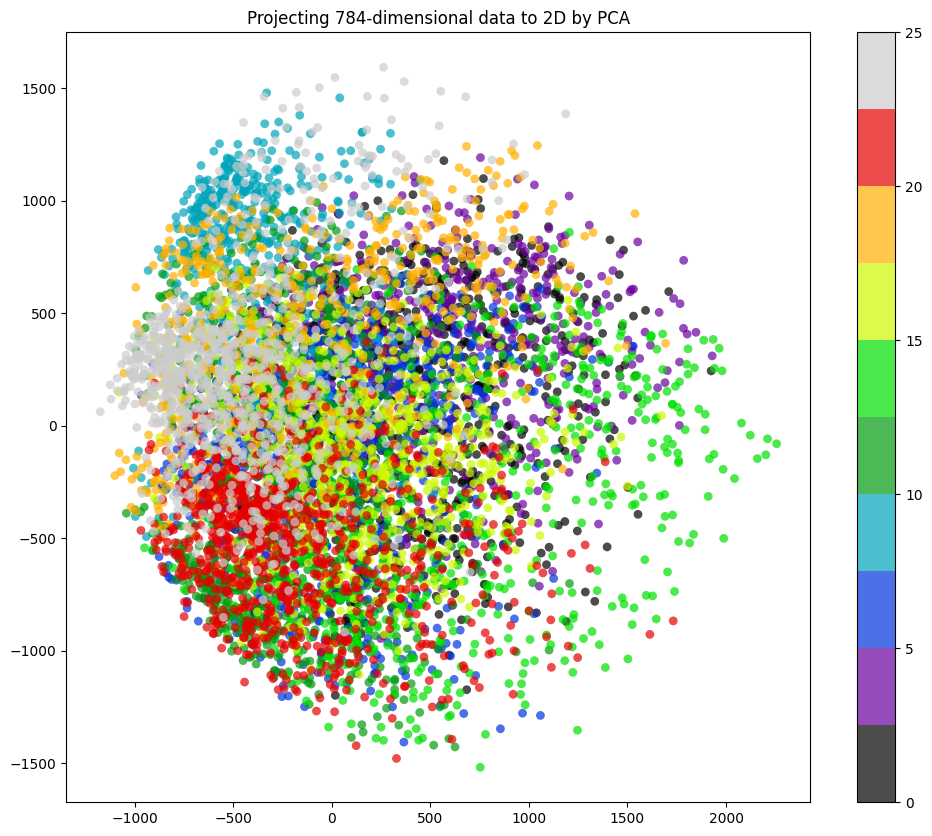

In [13]:
%%time

pca = PCA(n_components=2)
df_reduced = pca.fit_transform(df)

plt.figure(figsize=(12, 10))
plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=labels,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('Projecting %d-dimensional data to 2D by PCA' % df.shape[1]);

PCA сгруппировал все объекты в одну большую группу. Можно заметить определенные выделенные классы, но все-таки они слабо различимы.

CPU times: user 4min 2s, sys: 1.7 s, total: 4min 4s
Wall time: 20.9 s


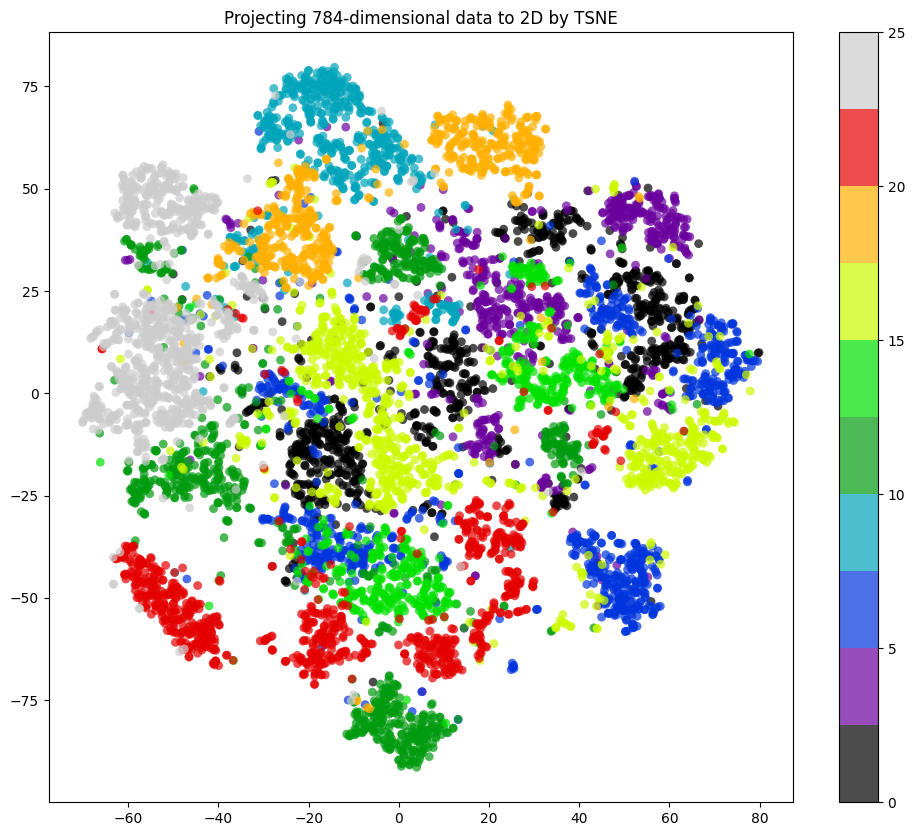

In [14]:
%%time

tsne = TSNE(random_state=42)
df_reduced = tsne.fit_transform(df)

plt.figure(figsize=(12, 10))
plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=labels,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('Projecting %d-dimensional data to 2D by TSNE' % df.shape[1]);

TSNE провел группировку, но отдельные части иногда смешиваются, а части одного класса разделены на несколько подгрупп.

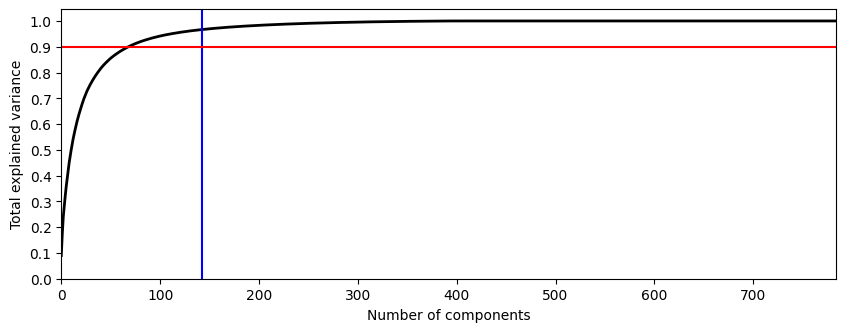

In [28]:
pca = PCA().fit(df)

plt.figure(figsize=(10, 3.5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, int(np.sqrt(len(df.columns))) * int(np.sqrt(len(df.columns))))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(142, c='b')
plt.axhline(0.9, c='r')
plt.show();

По графику можно заметить, что 40 пикселей описывают более 80% дисперсии, 75 - более 90%, а 300 описывают почти 100%. Это говорит о том, что размерность датасета можно существенно снизить, не сильно ухудшив при этом результаты кластеризации.

## Реализация K-Means

In [17]:
class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def predict(self, x):
        check_is_fitted(self)
        return self._get_labels(check_array(x))

    def fit(self, x, y=None):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        x = check_array(x)

        self.n_features_in_ = x.shape[1]
        self.cluster_centers_ = x[self.random_state_.choice(len(x), size=self.n_clusters, replace=False), :]
        max_center_shift = np.inf

        while max_center_shift > self.tol:
            self.labels_ = self._get_labels(x)

            new = np.empty((self.n_clusters, self.n_features_in_))
            for i in np.unique(self.labels_):
                new[i] = np.mean(x[self.labels_ == i], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new, axis=1))

            self.cluster_centers_ = new

        return self

    def _get_labels(self, x):
        return np.argmin(
            np.linalg.norm(x[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )

## Обучение

### Метрики

В датасете присутствуют однозначные ответы для всех данных, поэтому будут использованы Adjusted Rand Index (ARI), Adjusted Mutual Information (AMI) и Fowlkes-Mallows Index (FMI)

### Понижение размерности

Обучим сет с разным количеством атрибутов

- исходный датасет с 784 атрибутоми
- датасет с 300 атрибутами (100% дисперсии)
- датасет с 75 атрибутами (90% дисперсии)
- датасет с 40 атрибутами (80% дисперсии)

In [18]:
xs = [df, *(PCA(n_components=c).fit_transform(df) for c in [40, 75, 300])]

In [19]:
def train(est, params):
    params_combs = [
        dict(param) for param in
        itertools.product(*([(name, v) for v in vs] for (name, vs) in params.items()))
    ]

    results = []

    for x in xs:
        best_ari = None
        best_ami = None
        best_fmi = None

        for param in params_combs:
            e = clone(est).set_params(**param)
            start_time = time.perf_counter()
            pred = e.fit_predict(x)
            pred_time = (time.perf_counter() - start_time)

            ari = adjusted_rand_score(labels, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, pred_time, param

            ami = adjusted_mutual_info_score(labels, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, pred_time, param

            fmi = fowlkes_mallows_score(labels, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, pred_time, param

        print(
            f"Best params for {x.shape[1]}:",
            f"By ARI: {best_ari[2]}",
            f"By AMI: {best_ami[2]}",
            f"By FMI: {best_fmi[2]}",
            "",
            sep="\n",
        )

        res = {
            "Clusterer": est.__class__.__name__,
            "Dimension": x.shape[1],
            "Fit_predict time, s": np.mean([best_ari[1], best_ami[1], best_fmi[1]]),
            "ARI": best_ari[0],
            "AMI": best_ami[0],
            "FMI": best_fmi[0]
        }

        results.append(res)

    path = pathlib.Path("train_res.csv")
    pd.DataFrame(results).to_csv(path, mode="a", header=not path.exists())

### My K-means

In [20]:
train(
    MyKMeans(n_clusters=10, random_state=0),
    params={}
)

Best params for 784:
By ARI: {}
By AMI: {}
By FMI: {}

Best params for 40:
By ARI: {}
By AMI: {}
By FMI: {}

Best params for 75:
By ARI: {}
By AMI: {}
By FMI: {}

Best params for 300:
By ARI: {}
By AMI: {}
By FMI: {}



### K-means

In [21]:
train(
    KMeans(n_clusters=10, n_init='auto', random_state=0),
    params={"algorithm": ["lloyd", "elkan"]}
)

Best params for 784:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}

Best params for 40:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}

Best params for 75:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}

Best params for 300:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}



### DBSCAN

In [22]:
train(
    DBSCAN(n_jobs=4),
    params={
        "eps": [0.5, 1, 2, 4,8,16,32,64,128,256,512,1024,2048],
        "min_samples": [5, 25, 125, 250]
    }
)

Best params for 784:
By ARI: {'eps': 1024, 'min_samples': 5}
By AMI: {'eps': 1024, 'min_samples': 5}
By FMI: {'eps': 0.5, 'min_samples': 5}

Best params for 40:
By ARI: {'eps': 1024, 'min_samples': 5}
By AMI: {'eps': 1024, 'min_samples': 25}
By FMI: {'eps': 1024, 'min_samples': 25}

Best params for 75:
By ARI: {'eps': 1024, 'min_samples': 5}
By AMI: {'eps': 1024, 'min_samples': 5}
By FMI: {'eps': 1024, 'min_samples': 5}

Best params for 300:
By ARI: {'eps': 1024, 'min_samples': 5}
By AMI: {'eps': 1024, 'min_samples': 5}
By FMI: {'eps': 0.5, 'min_samples': 5}



### Результаты

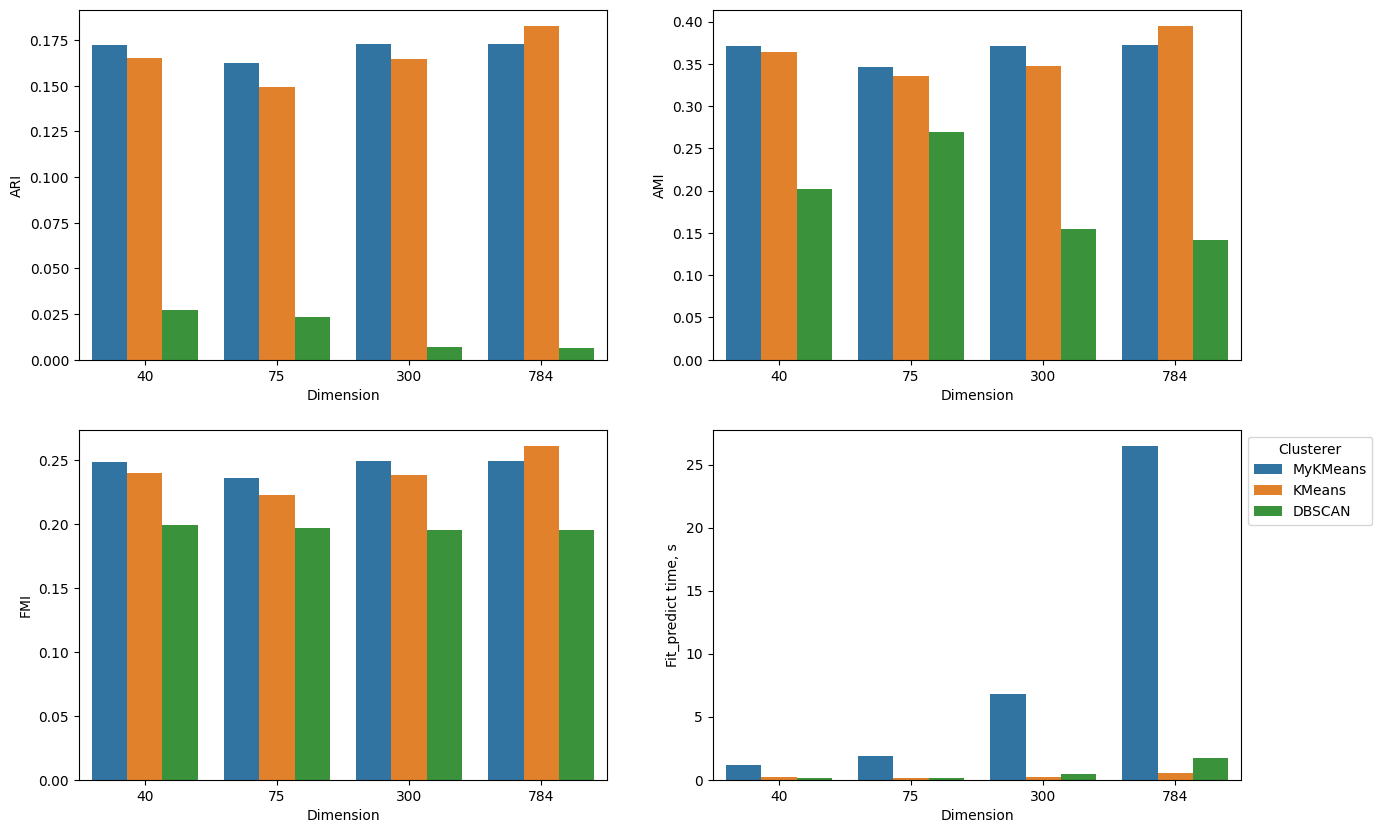

In [26]:
results = pd.read_csv(pathlib.Path("train_res.csv"))
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

for y, ax in zip(
    ["ARI", "AMI", "FMI", "Fit_predict time, s"], axs.flatten()
):
    sns.barplot(results, x="Dimension", y=y, hue="Clusterer", ax=ax)
    if y == "Fit_predict time, s":
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()

### Вывод

Уменьшение размерности данных достаточно сильно повлияло на время обучения, время MyKMeans росло практически экспоненциально. При этом качество результатов менялось весьма не значительно. 

Дольше всех работал алгоритм MyKMeans, так как очевидно, что данный код не имеет параллельности и качественных оптимизаций. Однако библиотечный KMeans по сравнению с DBSCAN оказался эффективнее.

Качественно обе реализации KMeans приблизительно равны и сильно опережают алгоритм DBSCAN.